# **Lab3 : Photo Mosaic using KNN Clustering**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Feature Preparation for tile images

Locate the directory containing your tile images dataset. Ensure that the images in this directory have a wide range of colors to create a visually appealing mosaic. List all the image filenames in the directory to `fnames`. ***Select a subset of these filenames to use as tile images, with at least 100 images in total, and assign them to `fnames_mini`.***

In [2]:
### START CODE HERE ###
from os import listdir
from os.path import isfile, join


fnames = [f for f in listdir('asset/images') if isfile(join('asset/images', f))]
fnames_mini = fnames
numImg = len(fnames)
### END CODE HERE ###

In [3]:
assert len(fnames_mini) >= 100, "Less than 100 images found in the subset. Ensure the directory has at least 100 images."

### Loading and Resizing Tile Images
Define the size to which all tile images will be resized. This ensures consistency in the dimensions of the tile images. 
Iterate over the list of tile image filenames. Resize the image to the predefined `tile_size`. Append the processed image to the list of `tiles`.


In [4]:
### START CODE HERE ###
tiles = []

tile_size = (120, 120)

images = [cv2.resize(plt.imread('asset/images/' + fname), tile_size) for fname in fnames_mini]

tiles.extend(images)
### END CODE HERE ###

In [5]:
assert len(tiles) == len(fnames_mini), "The number of processed images does not match the number of filenames. Ensure all images are loaded and processed correctly."

Randomly select a few tile images from your dataset and display them using Matplotlib. This will help you visually inspect the tile images to ensure they are loaded and processed correctly.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/1.png)
</details>

3


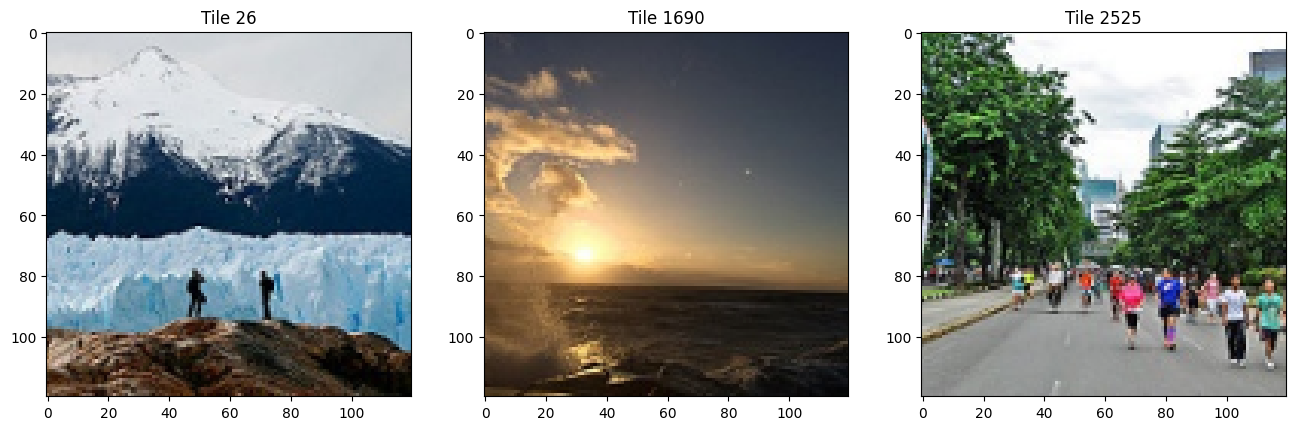

In [6]:
### START CODE HERE ###
def subplot(axs, img, title, axis='off', cmap="viridis"):
    axs.imshow(img, cmap=cmap)
    axs.set_title(title)
    axs.axis(axis)

fig, axs = plt.subplots(1, 3, figsize = (16, 9))

random_elements = random.choices(range(len(tiles)), k=3)

print(len(random_elements))
for i, element in enumerate(random_elements):
    subplot(axs[i], np.array(tiles[element]), 'Tile ' + str(element), axis='on')

### END CODE HERE ###

Calculate the average color for each tile image and add the resulting mean color to the `colors` list.

In [7]:
### START CODE HERE ###
colors = (np.array([np.mean(tiles[i], axis=(0, 1)) for i in range(len(tiles))])).astype(np.uint8)




### END CODE HERE ###    

Create a visual representation of the mean colors calculated for each tile image. 
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
- Example output where `numImg = 10`

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/2-1.png)

- Example output where `numImg = 500`

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/2-2.png)
</details>

234


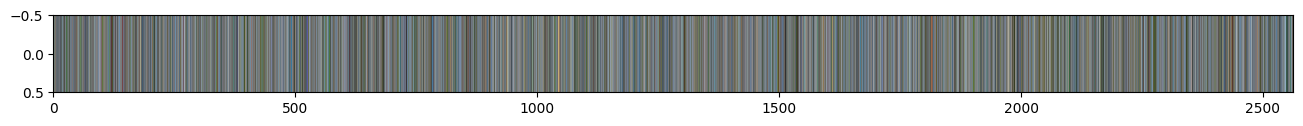

In [8]:
### START CODE HERE ###
news = colors.reshape((1, len(tiles), 3))
fig, axs = plt.subplots(1, 1, figsize = (16, 1))
axs.imshow(news, aspect='auto')
print(np.max(news))

### END CODE HERE ###

## Preparation for main image

Load the main image.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/3.png)

</details>

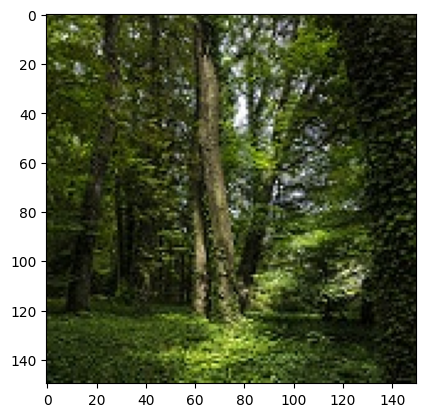

In [9]:
### START CODE HERE ###
og_img = plt.imread('asset/images/' + random.choice(fnames))

main_img = og_img.copy()
plt.imshow(og_img)
### END CODE HERE ###

Compute the number of tiles required in the height and width dimensions of the image. This is based on the size of each tile and the dimensions of the original image. Define the dimensions for the resized image grid.

In [10]:
### START CODE HERE ###
height = 120
width = 160
dim = (width, height)

### END CODE HERE ###

Visualize the resized image to ensure proper alignment with the tile grid.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/4.png)

</details>

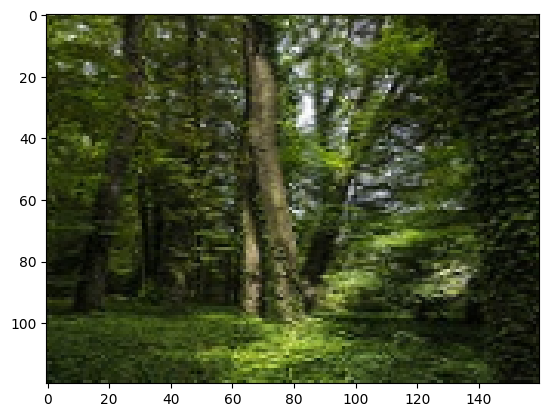

In [11]:
### START CODE HERE ###
resize_img = cv2.resize(og_img, dim)
plt.imshow(resize_img)
### END CODE HERE ###

Create a KDTree from the list of mean colors of the tile images using [`spatial.KDTree()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html). Use `closest_tiles` to store the index of the closest tile image for each pixel in the resized main image.
***Try with difference value of k in `tree.query()`***

In [12]:
### START CODE HERE ###
tree = spatial.KDTree(colors)
distance, closest_tiles = tree.query(resize_img, k=1)

### END CODE HERE ###

In [13]:
assert closest_tiles.shape == (height, width), "The shape of the closest_tiles array does not match the expected dimensions."

Visualizing `closest_tiles` Indices
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/5.png)

</details>

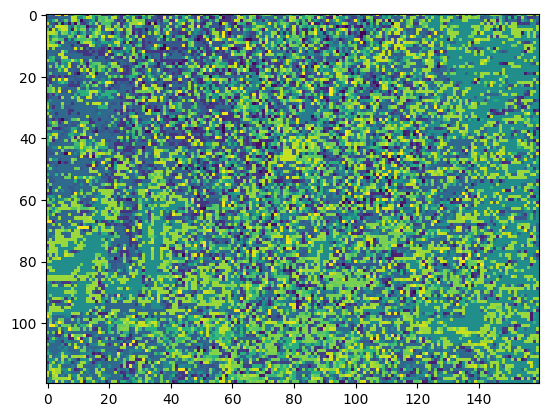

In [14]:
### START CODE HERE ###
plt.imshow(closest_tiles)
### END CODE HERE ###

Create a copy of the resized main image and replace each pixel region with the corresponding tile image based on the closest tile indices to assemble the final photo mosaic.

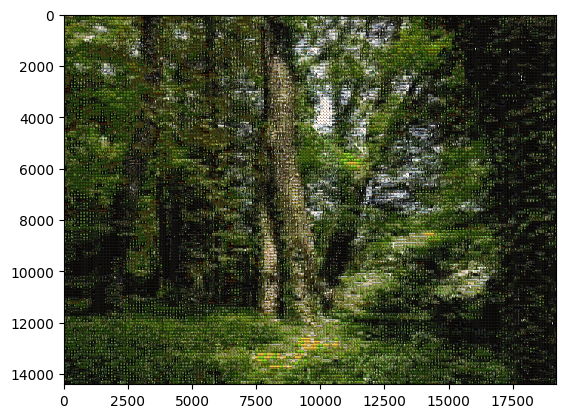

In [27]:
### START CODE HERE ###
import math
output = resize_img.copy()

def create_mosaic(target_image, block_size, tiles, tree, k=1):
    h, w = target_image.shape[:2]
    h1, w1 = tiles[0].shape[:2]
    nh = math.ceil(h/block_size[0])
    nw = math.ceil(w/block_size[1])
    mosaic = np.zeros((h1*nh, w1*nw, 3), dtype=np.uint8)

    for i in range(0, nh):
        for j in range(0, nw):
            block = target_image[i*block_size[0]:(i+1)*block_size[0], j*block_size[1]:(j+1)*block_size[1]]
            mean_color_block = np.mean(block, axis=(0, 1))
            
            distance, closest_tiles_idx = tree.query(mean_color_block, k)
            if closest_tiles_idx.size > 1:
                closest_tiles_idx = closest_tiles_idx[0]
            closest_tile = tiles[closest_tiles_idx]

            mosaic[i*h1:(i+1)*h1, j*w1:(j+1)*w1] = closest_tile

    return np.array(mosaic)

output2 = cv2.resize(output, (6000, 7000))

def create_mosaic2(target_image, tiles, tree, k=1):
    h, w = target_image.shape[:2]
    h1, w1 = tiles[0].shape[:2]
    nh = math.ceil(h/h1)
    nw = math.ceil(w/w1)
    mosaic = np.zeros_like(target_image, dtype=np.uint8)

    for i in range(0, nh):
        for j in range(0, nw):
            block = target_image[i*h1:(i+1)*h1, j*w1:(j+1)*w1]
            mean_color_block = np.mean(block, axis=(0, 1))
            
            distance, closest_tiles_idx = tree.query(mean_color_block, k)
            if closest_tiles_idx.size > 1:
                closest_tiles_idx = closest_tiles_idx[-1]
            closest_tile = tiles[closest_tiles_idx]
            mosaic[i*h1:(i+1)*h1, j*w1:(j+1)*w1] = closest_tile[:h - i*h1, :w - j*w1]

    return np.array(mosaic)


mosaic = create_mosaic(output, (1, 1), tiles, tree)
# mosaic = create_mosaic2(output2, tiles, tree)
plt.imshow(mosaic)

### END CODE HERE ###

Create a side-by-side comparison of four images: the original image, the resized main image, the final mosaic, and the KDTree tile index grid. This helps visualize the mosaic creation process.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/6.png)

</details>

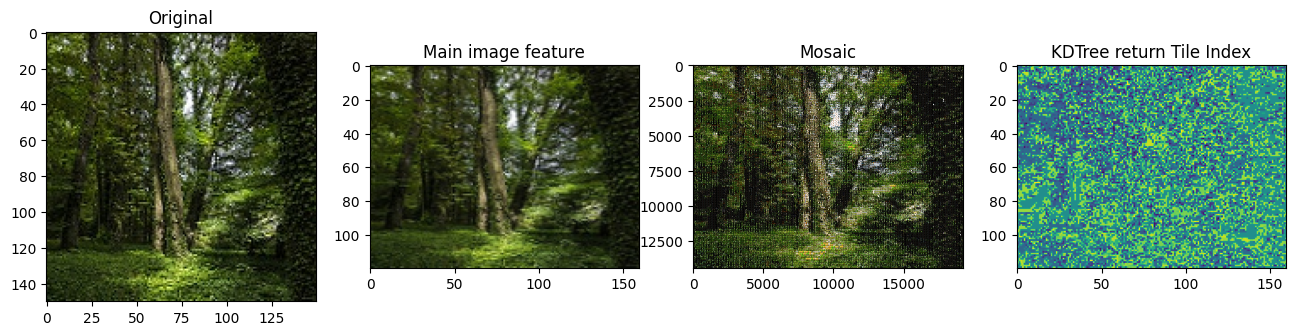

In [28]:
### START CODE HERE ###
fig, axs = plt.subplots(1, 4, figsize = (16, 9))

subplot(axs[0], og_img, 'Original', axis='on')
subplot(axs[1], resize_img, 'Main image feature', axis='on')
subplot(axs[2], mosaic, 'Mosaic', axis='on')
subplot(axs[3], closest_tiles, 'KDTree return Tile Index', axis='on')




### END CODE HERE ###

## Save the final photo mosaic 
Experiment with at least 3 different values of k and save the final photo.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- Saved output should resemble this, but not be identical

![image.gif](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab3_Image-Clustering/asset/7.gif?raw=true)


- k = 1

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k1.png)

- k = 10

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k10.png)

- k = 50

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/image_processing-2024/master/Lab3_Image-Clustering/asset/output-k50.png)
</details>

In [31]:
### START CODE HERE ###

plt.imsave('mosaic.jpg', mosaic)

### END CODE HERE ###

---

## **Question** 
1. How does changing the size of the tiles influence the overall quality and appearance of the mosaic? Conduct an analysis comparing two different tile sizes and discuss the trade-offs involved in terms of computational complexity and visual fidelity.
<br>
ยิ่ง tiles size มีค่าลดลง ยิ่งได้ความละเอียดที่เพิ่มขึ้น แต่จำนวน iterations ที่ต้องใช้ในการสร้างรูปก็จะมากขึ้นด้วย(โปรแกรมทำงานช้าลง)
2. Explain the effect of changing the value of K (number of nearest neighbors) on the mosaic image.
ยิ่งมีค่าใกล้กับ 1 จะยิ่งมีค่าขอสีใกล้กับค่าสีของ pixel มากเท่านั้น แต่ยิ่งไกล 1 ก็จะยิ่งออกห่างจาก pixel นั้นๆ

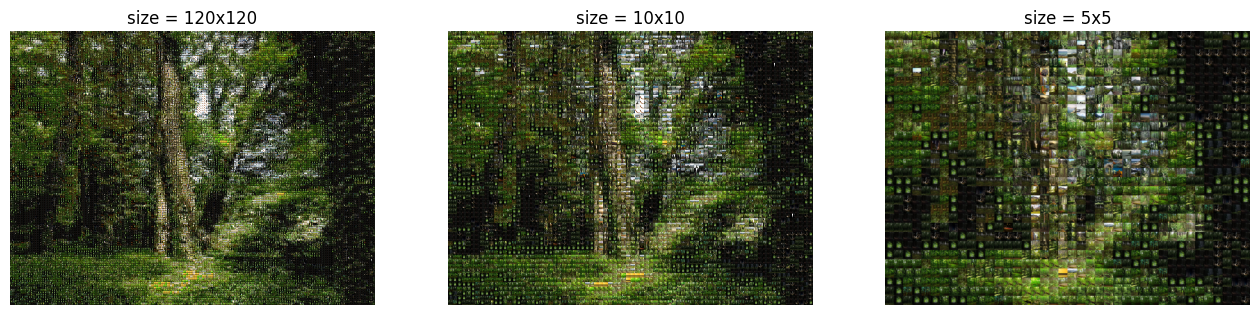

In [29]:
fig,axs = plt.subplots(1,3,figsize=(16,9))
subplot(axs[0], mosaic, 'size = 120x120', axis='off')
mosaic_resize = create_mosaic(output, (2, 2), tiles, tree)
subplot(axs[1],mosaic_resize,'size = 10x10',axis='off')
mosaic_resize = create_mosaic(output, (4, 4), tiles, tree)
subplot(axs[2],mosaic_resize,'size = 5x5',axis='off')

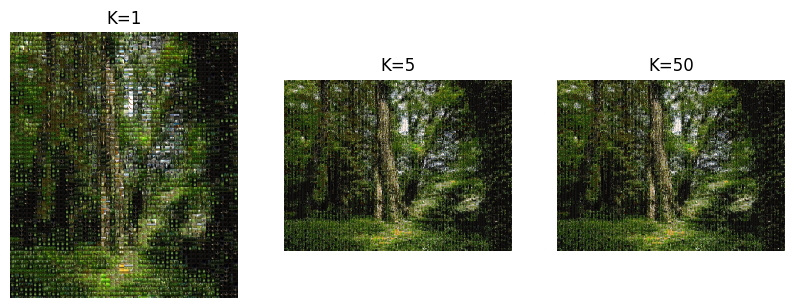

In [25]:
fig,axs = plt.subplots(1,3,figsize = (10,6))
subplot(axs[0],mosaic,'K=1')
mosaic_K2 = create_mosaic(output, (1, 1), tiles, tree, 5)
subplot(axs[1],mosaic_K2,'K=5')
mosaic_K5 = create_mosaic(output, (1, 1), tiles, tree, 50)
subplot(axs[2],mosaic_K5,'K=50')